### **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary


d:\miniconda3\envs\torch11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    


 ## 3. 查看图片

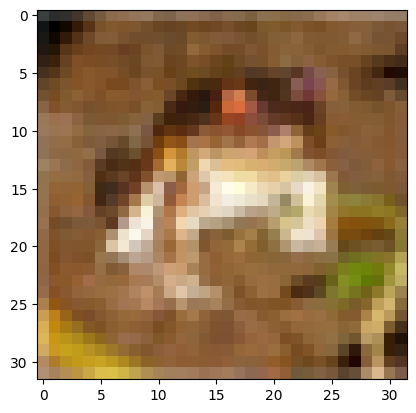

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

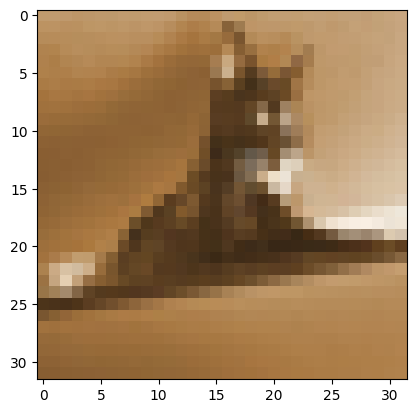

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

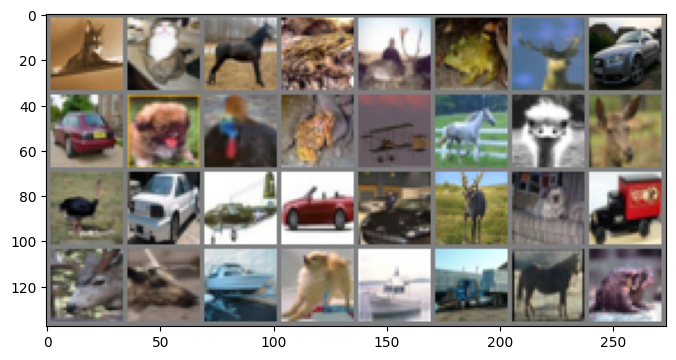

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（ShuffleNet）

ShuffleNet是旷视科技提出的一种计算高效的CNN模型，其和MobileNet和SqueezeNet等一样主要是想应用在移动端。所以，ShuffleNet的设计目标也是如何利用有限的计算资源来达到最好的模型精度，这需要很好地在速度和精度之间做平衡。

ShuffleNet的核心是采用了两种操作：**pointwise group convolution和channel shuffle**，这在保持精度的同时大大降低了模型的计算量。目前移动端CNN模型主要设计思路主要是两个方面：模型结构设计和模型压缩。ShuffleNet和MobileNet一样属于前者，都是通过设计更高效的网络结构来实现模型变小和变快，而不是对一个训练好的大模型做压缩或者迁移。接下来我们将详细讲述ShuffleNet的设计思路，网络结构及模型效果，最后使用Pytorch来实现ShuffleNet网络。



### Channel Shuffle

**ShuffleNet的核心设计理念是对不同的channels进行shuffle来解决group convolution带来的弊端**。Group convolution是将输入层的不同特征图进行分组，然后采用不同的卷积核再对各个组进行卷积，这样会降低卷积的计算量。因为一般的卷积都是在所有的输入特征图上做卷积，可以说是全通道卷积，这是一种通道密集连接方式（channel dense connection）。而group convolution相比则是一种通道稀疏连接方式（channel sparse connection）。

使用group convolution的网络如Xception，MobileNet，ResNeXt等。Xception和MobileNet采用了depthwise convolution，这其实是一种比较特殊的group convolution，因此此时分组数恰好等于通道数，意味着每个组只有一个特征图。但是这些网络存在一个**很大的弊端是采用了密集的1x1卷积**，或者说是dense pointwise convolution，这里说的密集指的是卷积是在所有通道上进行的。所以，实际上比如**ResNeXt模型中1x1卷积基本上占据了93.4%的乘加运算**。那么不如也对1x1卷积采用channel sparse connection，那样计算量就可以降下来了。

除此之外，group convolution存在另外一个弊端，如图1-a所示，其中GConv是group convolution，这里分组数是3。可以看到当堆积GConv层后一个问题是不同组之间的特征图是不通信的，这就好像分了三个互不相干的路，大家各走各的，这目测会降低网络的特征提取能力。这样你也可以理解为什么Xception，MobileNet等网络采用密集的1x1卷积，因为要保证group convolution之后不同组的特征图之间的信息交流。但是达到上面那个目的，我们不一定非要采用dense pointwise convolution。如图1-b所示，你可以对group convolution之后的特征图进行“重组”，这样可以保证接下了采用的group convolution其输入来自不同的组，因此信息可以在不同组之间流转。**这个操作等价于图1-c，即group convolution之后对channels进行shuffle，但并不是随机的，其实是“均匀地打乱”。**

![快速理解ShuffleNetV1（结合代码）_shufflenetv1代码-CSDN博客](https://img-blog.csdnimg.cn/f7e70c042c0e466b9321d1e68444d48f.png)

- 图a是简单的组卷积实现过程，这里存在的问题是输出通道只与输入的某些通道有关，降低通道组间的信息流动能力，降低了信息表达能力。
- 图b是将每个组中的特征图均匀混合，也就是混洗（Shuffle），这样可以**更好地获取全局信息**，图c是图b的等价效果。

### 网络单元 Shuffle Unit

 Channel Shuffle 的原理，就可以设计Shuffle Unit 了，其实很简单，ShuffleNet的基本单元是在一个残差单元的基础上改进而成的。

- 图a是ResNet中的bottleneck unit，但这里用 3×3 的DWConv代替原来的 3 × 3 Conv（主要是为了降低计算量）；
- 图b将图a中的两端1×1Conv换成了Group Conv；同时在DWConv之前使用了Channel Shuffle，该单元没有对图像大小进行调整；还有就是，经过DWConv后不进行ReLU激活函数;

对于残差单元，如果stride=1时，此时输入与输出shape一致可以直接相加，而当stride=2时，通道数增加，而特征图大小减小，此时输入与输出不匹配。一般情况下可以采用一个1x1卷积将输入映射成和输出一样的shape。但是在ShuffleNet中，却采用了不一样的策略。

- 图c中的DWConv的步长设置为2，同时旁路连接中添加了一个步长为2的平均池化 3x3 avg pool，这样得到和输出一样大小的特征图，并在最后使用Concatenate相连两条分支（不是相加），这种设计在扩大了通道维度的同时并没有增加很多的计算量。**（add是通道数值相加，concat是通道堆叠）**

![Shufflenet V1 — MMPretrain 1.0.0rc8 documentation](https://user-images.githubusercontent.com/26739999/142575730-dc2f616d-80df-4fb1-93e1-77ebb2b835cf.png)



### ShuffleNet 网络结构

基于上面改进的ShuffleNet基本单元，设计的ShuffleNet模型如表所示。类似与残差网络的方法，一开始使用简单的卷积和max pool，后面进行堆叠ShuffleNet的基本单元，和残差的设计理念是一样的。

其中 $g$ **控制了group convolution中的分组数**，分组越多，在相同计算资源下，可以使用更多的通道数，所以 $g$ 越大时，采用了更多的卷积核。这里给个例子，当 $g$ = 3 时，对于第一阶段的第一个基本单元，其输入通道数为24，输出通道数为240，但是其stride=2，那么由于原输入通过avg pool可以贡献24个通道，所以相当于左支只需要产生240-24=216通道，中间瓶颈层的通道数就为216/4=54。其他的可以以此类推。当完成三阶段后，采用global pool将特征图大小降为1x1，最后是输出类别预测值的全连接层。

![img](https://pic4.zhimg.com/80/v2-3331c0c1803d7289ee87b575b020a68b_1440w.webp)


#### 判断是否使用GPU

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

第一步我们需要构建我们的ShuffleBlock，里面就用到了我们的核心理念，Channel Shuffle，其实在程序上实现channel shuffle是非常容易的：

假定将输入层分为 g 组，总通道数为 $g×n$ ，首先你将通道那个维度拆分为 $(g,n)$ 两个维度，然后将这两个维度转置变成 $(n,g)$ ，最后重新 reshape 成一个维度。如果你不太理解这个操作，你可以试着动手去试一下，发现仅需要简单的维度操作和转置就可以实现均匀的shuffle。利用channel shuffle就可以充分发挥group convolution的优点，而避免其缺点。

In [15]:
class ShuffleBlock(nn.Module):
    def __init__(self, groups):
        super(ShuffleBlock, self).__init__()
        self.groups = groups

    def forward(self, x):
        '''Channel shuffle: [N,C,H,W] -> [N,g,C/g,H,W] -> [N,C/g,g,H,w] -> [N,C,H,W]'''
        N,C,H,W = x.size()
        g = self.groups
        return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)

然后跟残差一样的理念，我们设置我们的Bottleneck，对于stride = 2的情况就加入一个Avg pool，这样就可以得到我们的基本模块了

In [16]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_channels = out_channels//4
        g = 1 if in_channels==24 else groups
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride, padding=1, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = F.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out

基于网络结构表，我们就可以定义我们的ShuffleNet了，首先是1x1的卷积和BN层，后面两个就是不断的堆叠我们的Bottleneck层，最后根据网络结构的表的参数，得到我们最后的ShuffleNetG2和ShuffleNetG3了。

In [17]:
class ShuffleNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(ShuffleNet, self).__init__()
        out_channels = cfg['out_channels']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_channels = 24
        self.layer1 = self._make_layer(out_channels[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_channels[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_channels[2], num_blocks[2], groups)
        self.linear = nn.Linear(out_channels[2], num_classes)

    def _make_layer(self, out_channels, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_channels = self.in_channels if i == 0 else 0
            layers.append(Bottleneck(self.in_channels, out_channels-cat_channels, stride=stride, groups=groups))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 根据表中的数据定义
def ShuffleNetG2(num_classes = 10):
    cfg = {
        'out_channels': [200,400,800],
        'num_blocks': [4,8,4],
        'groups': 2
    }
    return ShuffleNet(cfg, num_classes)

def ShuffleNetG3(num_classes = 10):
    cfg = {
        'out_channels': [240,480,960],
        'num_blocks': [4,8,4],
        'groups': 3
    }
    return ShuffleNet(cfg, num_classes)

In [18]:
net = ShuffleNetG2(num_classes=10).to(device)

### summary查看网络

我们可以通过summary来看到，模型的维度的变化，这个也是和论文是匹配的，经过层后shape的变化，是否最后也是输出(batch,shape)

In [19]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]              72
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 44, 32, 32]           1,056
       BatchNorm2d-4           [-1, 44, 32, 32]              88
      ShuffleBlock-5           [-1, 44, 32, 32]               0
            Conv2d-6           [-1, 44, 16, 16]             396
       BatchNorm2d-7           [-1, 44, 16, 16]              88
            Conv2d-8          [-1, 176, 16, 16]           3,872
       BatchNorm2d-9          [-1, 176, 16, 16]             352
        AvgPool2d-10           [-1, 24, 16, 16]               0
       Bottleneck-11          [-1, 200, 16, 16]               0
           Conv2d-12           [-1, 50, 16, 16]           5,000
      BatchNorm2d-13           [-1, 50, 16, 16]             100
     ShuffleBlock-14           [-1, 50,

首先从我们summary可以看到，我们输入的是（batch，3，32，32）的张量，并且这里也能看到每一层后我们的图像输出大小的变化，最后输出10个参数，再通过softmax函数就可以得到我们每个类别的概率了。

我们也可以打印出我们的模型观察一下

In [20]:
print(net)

ShuffleNet(
  (conv1): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(24, 44, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shuffle1): ShuffleBlock()
      (conv2): Conv2d(44, 44, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=44, bias=False)
      (bn2): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(44, 176, kernel_size=(1, 1), stride=(1, 1), groups=2, bias=False)
      (bn3): BatchNorm2d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): AvgPool2d(kernel_size=3, stride=2, padding=1)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(200, 50, kernel_size=(1, 1), stride=(1, 1), groups=2, 

### 测试和定义网络

接下来可以简单测试一下，是否输入后能得到我们的正确的维度shape

In [21]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


定义网络和设置类别

In [22]:
net = ShuffleNetG2(num_classes=10)

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


如果想更加了解优化器和学习率策略的话，可以参考以下资料

- [Pytorch Note15 优化算法1 梯度下降（Gradient descent varients）](https://blog.csdn.net/weixin_45508265/article/details/117859824)
- [Pytorch Note16 优化算法2 动量法(Momentum)](https://blog.csdn.net/weixin_45508265/article/details/117874046)
- [Pytorch Note34 学习率衰减](https://blog.csdn.net/weixin_45508265/article/details/119089705)

这里决定迭代10次

In [23]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=1e-1)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)
import time
epoch = 20

## 6. 训练及可视化（增加TensorBoard可视化）

In [24]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/ShuffleNet.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [25]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/ShuffleNet', comment='ShuffleNet')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(1, 3, 32, 32)))

/tmp/ipykernel_2645886/1755635571.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return x.view(N,g,C//g,H,W).permute(0,2,1,3,4).reshape(N,C,H,W)


如果存在GPU可以选择使用GPU进行运行，并且可以设置并行运算

In [26]:
if device == 'cuda':
    net.to(device)
    net = nn.DataParallel(net) # 使用并行运算
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [27]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/20: 100%|██████████| 78/78 [00:01<00:00, 45.67it/s, Test Acc=0.346, Test Loss=1.72]


Epoch [  1/ 20]  Train Loss:2.543527  Train Acc:22.93% Test Loss:1.724631  Test Acc:34.58%  Learning Rate:0.100000


Test Epoch 2/20: 100%|██████████| 78/78 [00:01<00:00, 45.55it/s, Test Acc=0.378, Test Loss=2]   


Epoch [  2/ 20]  Train Loss:1.517884  Train Acc:43.01% Test Loss:2.002310  Test Acc:37.79%  Learning Rate:0.100000


Test Epoch 3/20: 100%|██████████| 78/78 [00:01<00:00, 44.93it/s, Test Acc=0.49, Test Loss=1.49] 


Epoch [  3/ 20]  Train Loss:1.314360  Train Acc:51.85% Test Loss:1.490109  Test Acc:49.03%  Learning Rate:0.100000


Test Epoch 4/20: 100%|██████████| 78/78 [00:01<00:00, 47.60it/s, Test Acc=0.547, Test Loss=1.31]


Epoch [  4/ 20]  Train Loss:1.159399  Train Acc:57.97% Test Loss:1.311152  Test Acc:54.68%  Learning Rate:0.100000


Test Epoch 5/20: 100%|██████████| 78/78 [00:01<00:00, 46.65it/s, Test Acc=0.607, Test Loss=1.18]


Epoch [  5/ 20]  Train Loss:1.040222  Train Acc:62.82% Test Loss:1.179275  Test Acc:60.66%  Learning Rate:0.100000


Test Epoch 6/20: 100%|██████████| 78/78 [00:01<00:00, 47.93it/s, Test Acc=0.616, Test Loss=1.09]


Epoch [  6/ 20]  Train Loss:0.952787  Train Acc:66.25% Test Loss:1.093483  Test Acc:61.65%  Learning Rate:0.100000


Test Epoch 7/20: 100%|██████████| 78/78 [00:01<00:00, 45.46it/s, Test Acc=0.66, Test Loss=0.989] 


Epoch [  7/ 20]  Train Loss:0.874572  Train Acc:69.36% Test Loss:0.989161  Test Acc:65.96%  Learning Rate:0.100000


Test Epoch 8/20: 100%|██████████| 78/78 [00:01<00:00, 47.33it/s, Test Acc=0.681, Test Loss=0.942]


Epoch [  8/ 20]  Train Loss:0.805317  Train Acc:71.83% Test Loss:0.942337  Test Acc:68.09%  Learning Rate:0.100000


Test Epoch 9/20: 100%|██████████| 78/78 [00:01<00:00, 47.49it/s, Test Acc=0.692, Test Loss=0.875]


Epoch [  9/ 20]  Train Loss:0.754513  Train Acc:73.90% Test Loss:0.875162  Test Acc:69.16%  Learning Rate:0.100000


Test Epoch 10/20: 100%|██████████| 78/78 [00:01<00:00, 47.51it/s, Test Acc=0.719, Test Loss=0.842]


Epoch [ 10/ 20]  Train Loss:0.715658  Train Acc:75.24% Test Loss:0.842443  Test Acc:71.88%  Learning Rate:0.100000


Test Epoch 11/20: 100%|██████████| 78/78 [00:01<00:00, 46.04it/s, Test Acc=0.693, Test Loss=0.931]


Epoch [ 11/ 20]  Train Loss:0.679201  Train Acc:76.53% Test Loss:0.930786  Test Acc:69.32%  Learning Rate:0.100000


Test Epoch 12/20: 100%|██████████| 78/78 [00:01<00:00, 47.52it/s, Test Acc=0.749, Test Loss=0.731]


Epoch [ 12/ 20]  Train Loss:0.646786  Train Acc:77.59% Test Loss:0.731182  Test Acc:74.86%  Learning Rate:0.100000


Test Epoch 13/20: 100%|██████████| 78/78 [00:01<00:00, 48.19it/s, Test Acc=0.757, Test Loss=0.725]


Epoch [ 13/ 20]  Train Loss:0.614621  Train Acc:78.57% Test Loss:0.725260  Test Acc:75.74%  Learning Rate:0.100000


Test Epoch 14/20: 100%|██████████| 78/78 [00:01<00:00, 46.52it/s, Test Acc=0.724, Test Loss=0.824]


Epoch [ 14/ 20]  Train Loss:0.599098  Train Acc:79.57% Test Loss:0.823643  Test Acc:72.37%  Learning Rate:0.100000


Test Epoch 15/20: 100%|██████████| 78/78 [00:01<00:00, 47.83it/s, Test Acc=0.726, Test Loss=0.814]


Epoch [ 15/ 20]  Train Loss:0.578047  Train Acc:80.02% Test Loss:0.813756  Test Acc:72.65%  Learning Rate:0.100000


Test Epoch 16/20: 100%|██████████| 78/78 [00:01<00:00, 46.78it/s, Test Acc=0.731, Test Loss=0.87] 


Epoch [ 16/ 20]  Train Loss:0.554816  Train Acc:81.06% Test Loss:0.869965  Test Acc:73.08%  Learning Rate:0.100000


Test Epoch 17/20: 100%|██████████| 78/78 [00:01<00:00, 47.13it/s, Test Acc=0.771, Test Loss=0.697]


Epoch [ 17/ 20]  Train Loss:0.530995  Train Acc:81.69% Test Loss:0.696719  Test Acc:77.14%  Learning Rate:0.100000


Test Epoch 18/20: 100%|██████████| 78/78 [00:01<00:00, 48.65it/s, Test Acc=0.732, Test Loss=0.858]


Epoch [ 18/ 20]  Train Loss:0.515668  Train Acc:82.23% Test Loss:0.857775  Test Acc:73.17%  Learning Rate:0.100000


Test Epoch 19/20: 100%|██████████| 78/78 [00:01<00:00, 47.36it/s, Test Acc=0.775, Test Loss=0.663]


Epoch [ 19/ 20]  Train Loss:0.496287  Train Acc:82.85% Test Loss:0.662742  Test Acc:77.45%  Learning Rate:0.100000


Test Epoch 20/20: 100%|██████████| 78/78 [00:01<00:00, 48.77it/s, Test Acc=0.78, Test Loss=0.649] 


Epoch [ 20/ 20]  Train Loss:0.475645  Train Acc:83.72% Test Loss:0.648839  Test Acc:78.00%  Learning Rate:0.100000


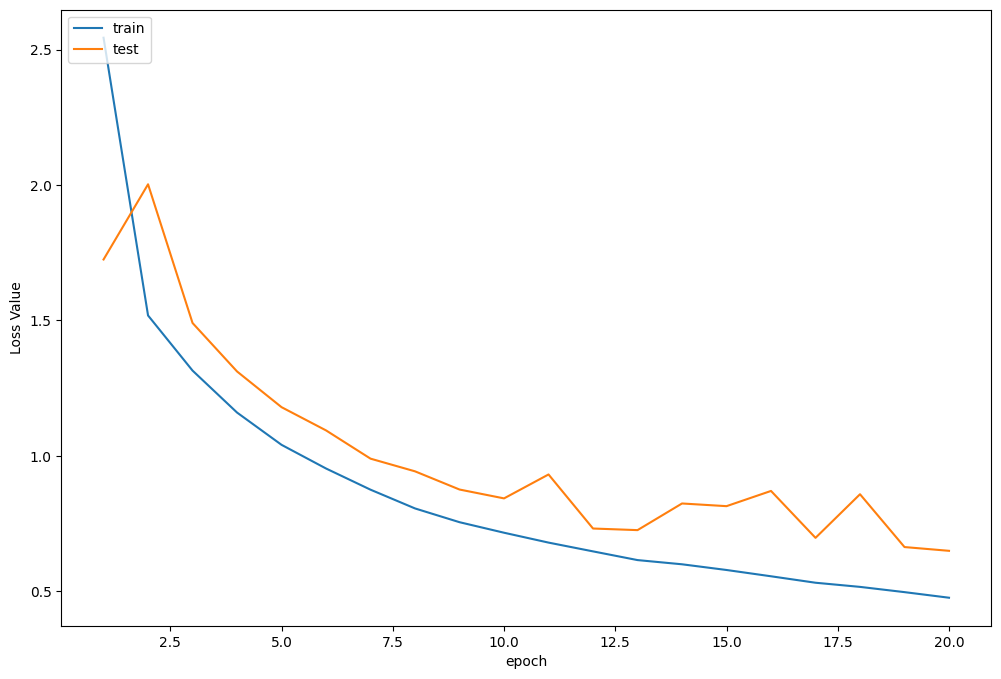

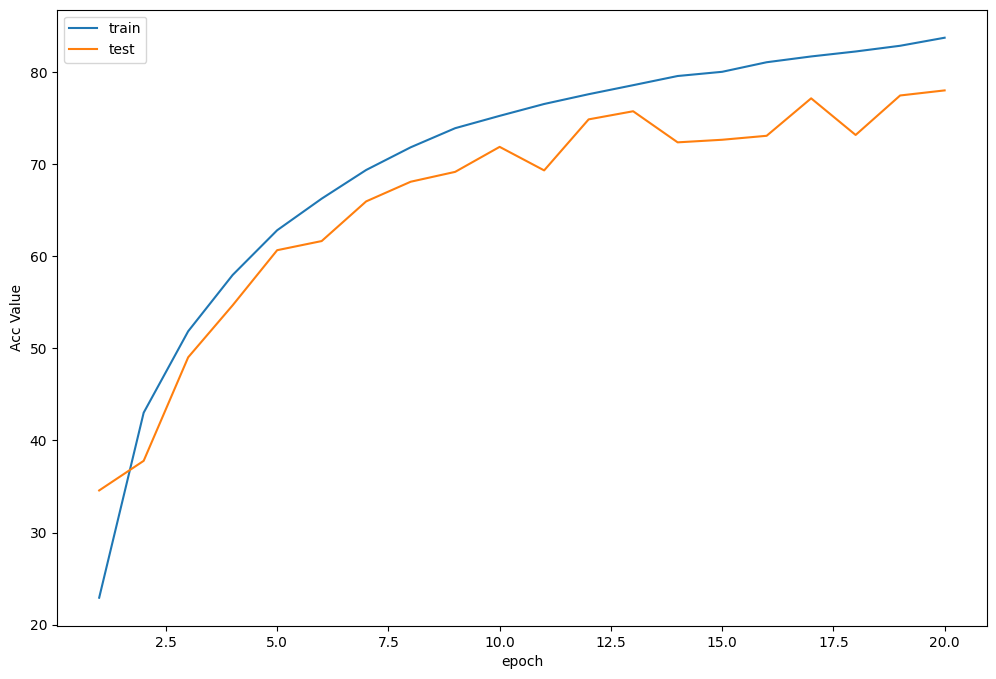

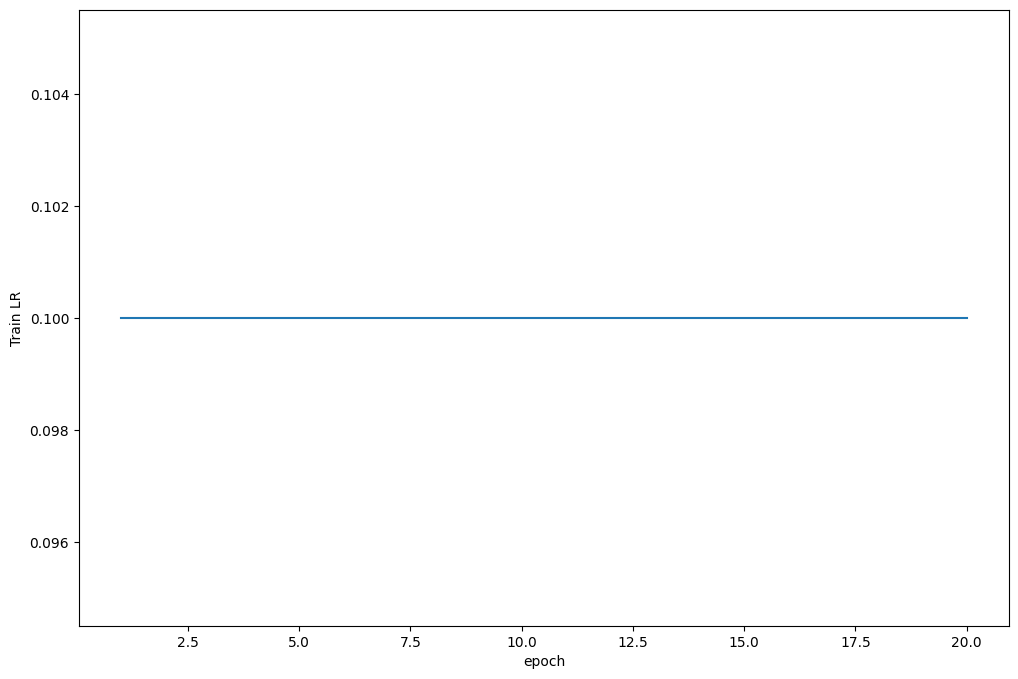

In [28]:
plot_history(epoch ,Acc, Loss, Lr)

In [29]:
# # 查看tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir './log'

## 7. 测试

In [30]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 77.95 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [31]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 83.67 %
Accuracy of automobile : 89.68 %
Accuracy of  bird : 67.94 %
Accuracy of   cat : 63.23 %
Accuracy of  deer : 78.08 %
Accuracy of   dog : 67.90 %
Accuracy of  frog : 87.50 %
Accuracy of horse : 81.54 %
Accuracy of  ship : 77.48 %
Accuracy of truck : 82.60 %


Accuracy Rate = 81.25%


<Figure size 2500x400 with 0 Axes>

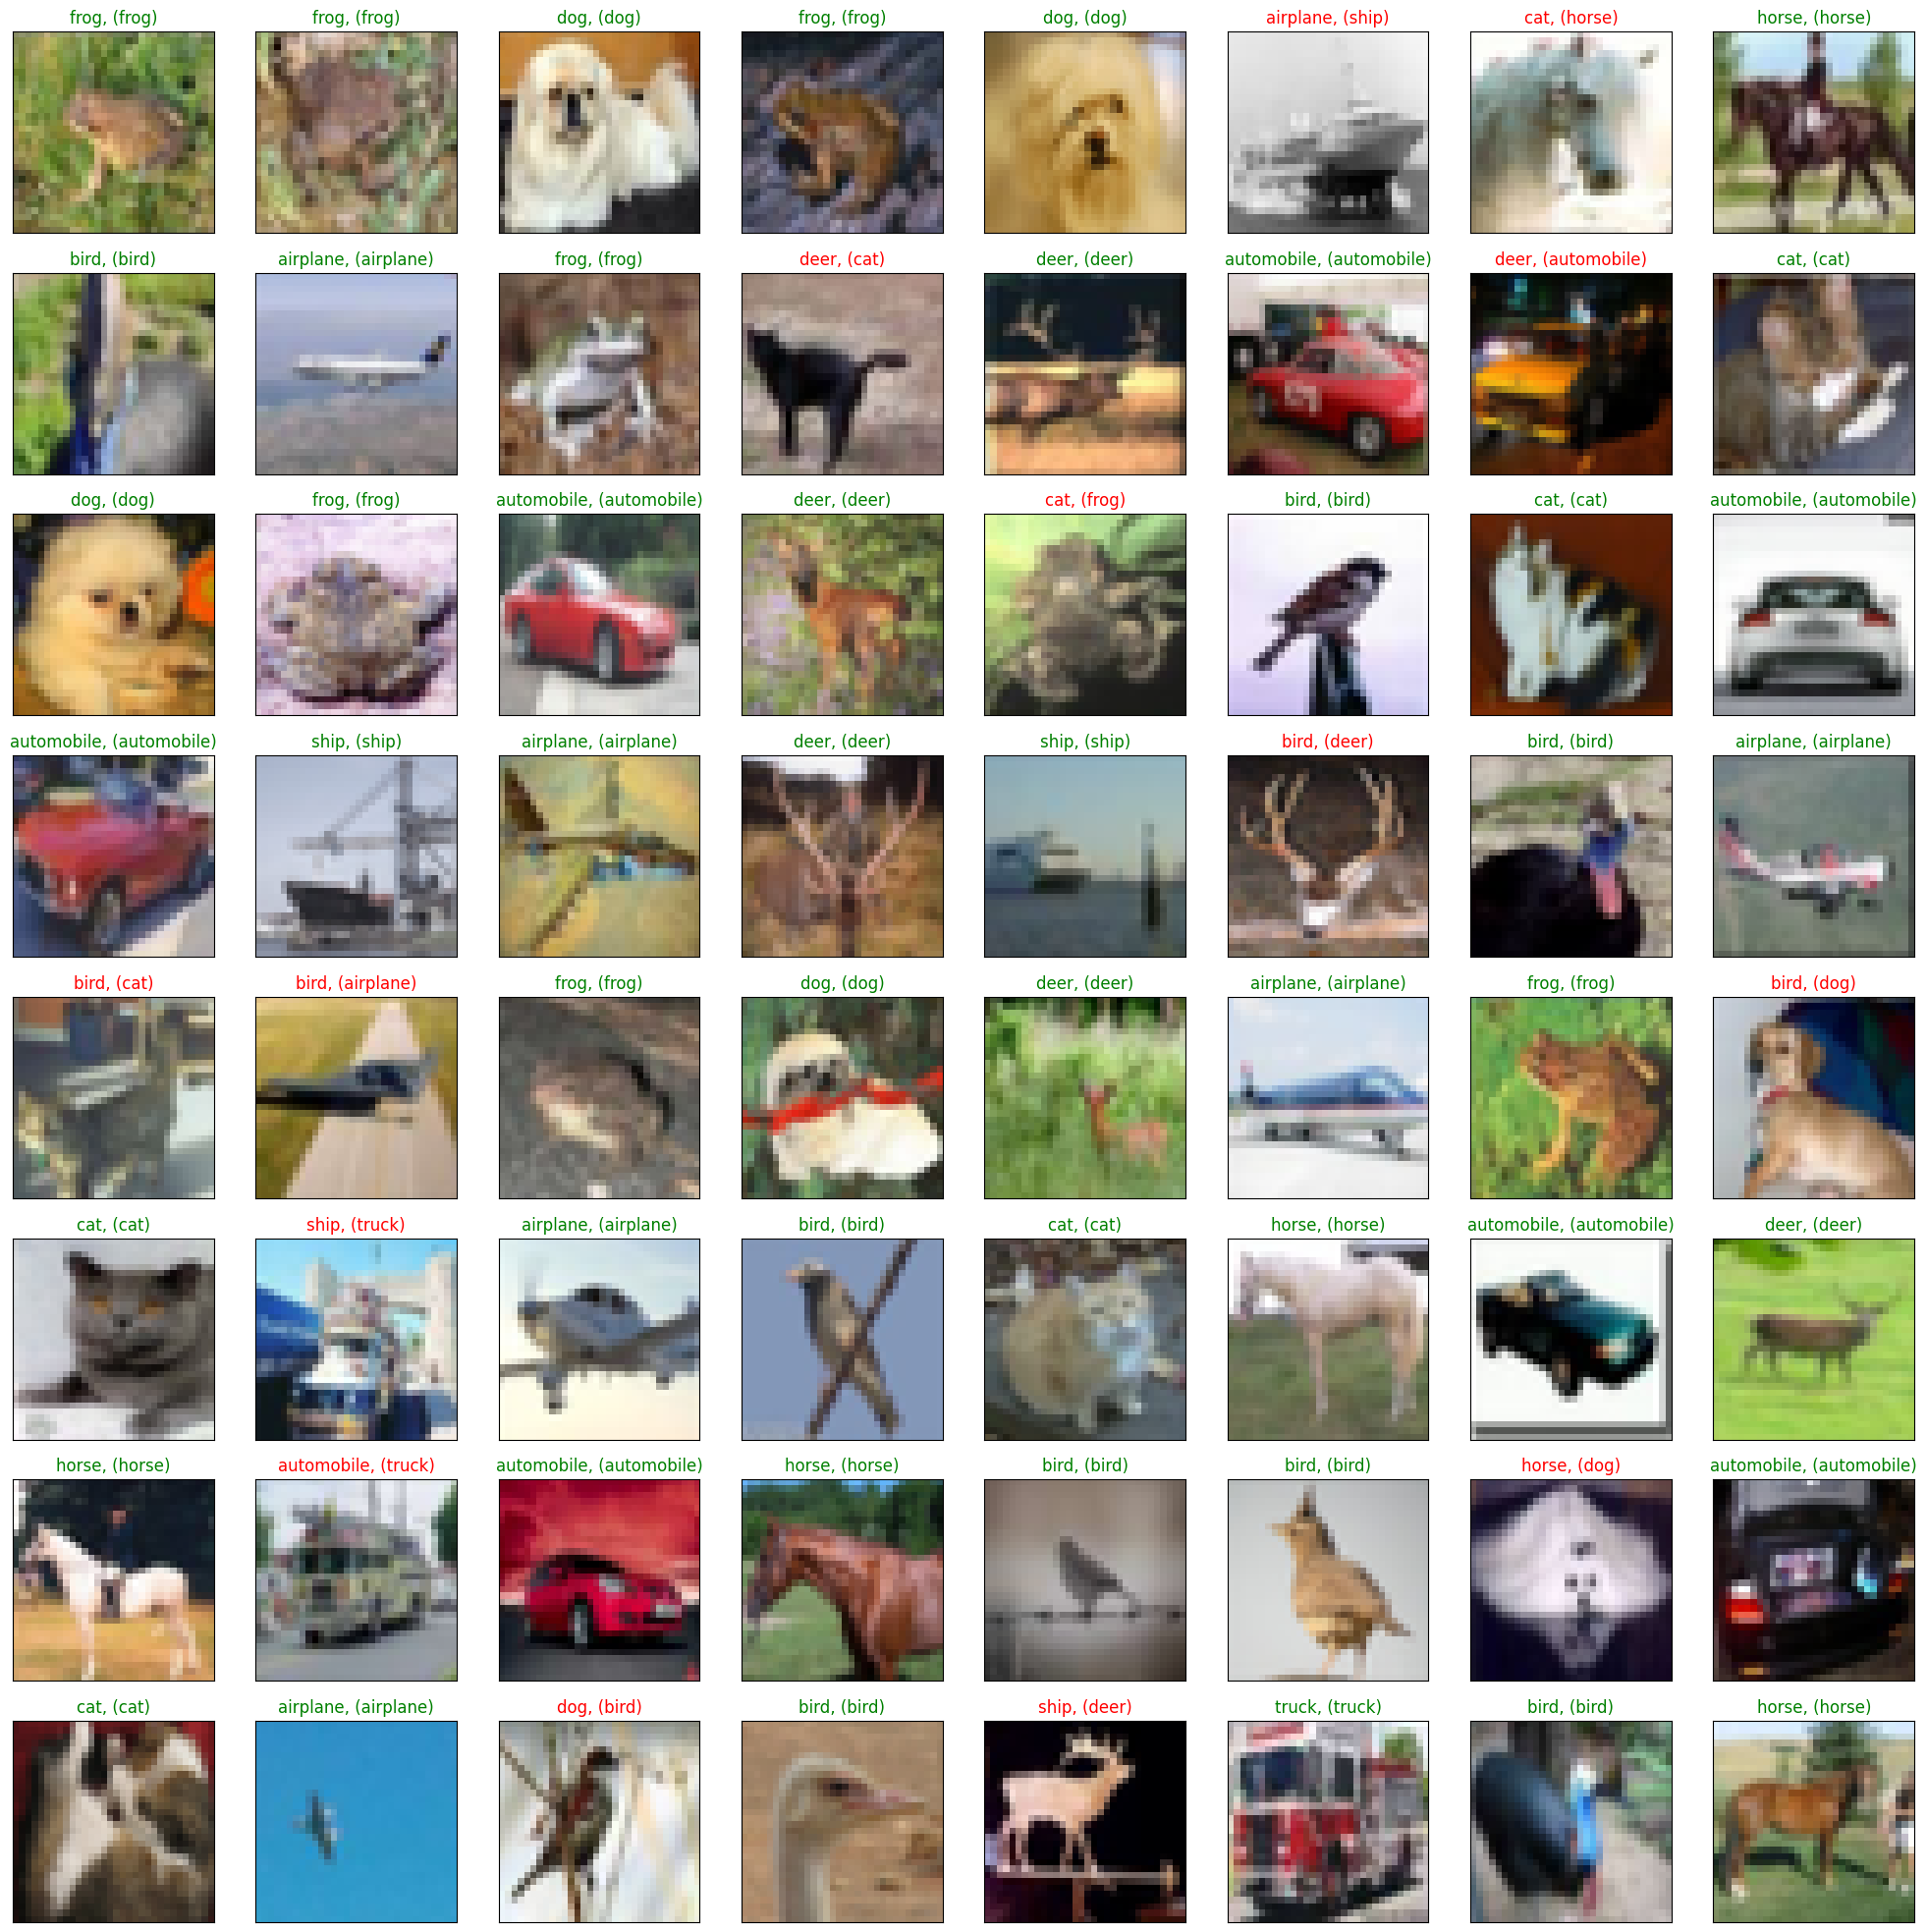

In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [33]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [26]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ShuffleNetG2(num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

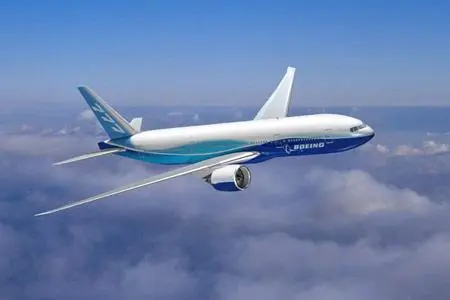

In [35]:
img

In [36]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.9983e-01, 1.6512e-07, 1.3221e-04, 7.2589e-07, 5.4374e-06, 3.2806e-08,
         1.3370e-06, 1.8729e-07, 2.4432e-05, 1.0642e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([10.7432], device='cuda:0')
分类 plane


<Response [200]>


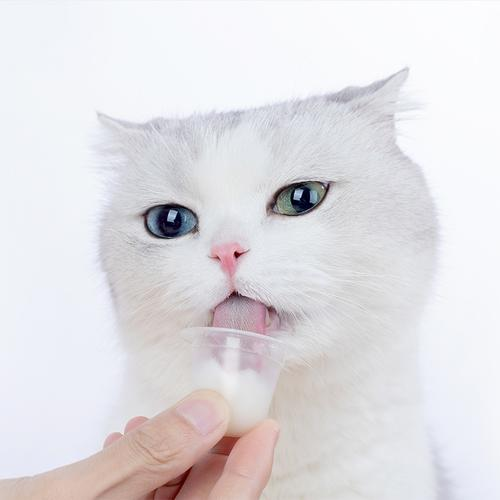

In [27]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [28]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.0227, 0.0007, 0.0323, 0.4136, 0.1379, 0.3642, 0.0113, 0.0127, 0.0033,
         0.0012]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
类别 3
tensor([2.3394], device='cuda:0')
分类 cat
